In [1]:
import pandas as pd
import numpy as np
from langdetect import detect as langdetect
import random
seed = 42
np.random.seed(seed)
random.seed(seed)
import sys
sys.path.append("..")
from data.labeled import CWA as cwa, CWR as cwr,LABELED_DIR

# Preprocess whole dataset

In [2]:
cwa.head()

,Account No,Organisation,City,Country,Region,Access,C40,Reporting Year,Risks to city's water supply,Adaptation action,Action description,City Location
0,1093,City of Atlanta,Atlanta,United States of America,North America,public,NaN,2018,Increased water stress or scarcity,Investment in existing water supply infrastruc...,"The city is building a new reservoir, fixing t...","(33.749, -84.388)"
1,1184,City of Austin,Austin,United States of America,North America,public,C40,2018,Increased water stress or scarcity,Conservation awareness and education,NaN,"(30.2672, -97.7431)"
2,1184,City of Austin,Austin,United States of America,North America,public,C40,2018,Increased water stress or scarcity,Conservation incentives,NaN,"(30.2672, -97.7431)"
3,1184,City of Austin,Austin,United States of America,North America,public,C40,2018,Increased water stress or scarcity,Water use restrictions,NaN,"(30.2672, -97.7431)"
4,1184,City of Austin,Austin,United States of America,North America,public,C40,2018,Increased water stress or scarcity,Efficiency regulations or standards,NaN,"(30.2672, -97.7431)"


In [3]:
cwr.head()

,Account No,Organisation,City,Country,Region,Access,C40,Reporting year,Risks to city's water supply,Timescale,Magnitude,Risk description,Current population,Population year,City Location
0,1093,City of Atlanta,Atlanta,United States of America,North America,public,NaN,2018,Increased water stress or scarcity,Short-term,Serious,The city depends on one river for water supply...,450182.0,2017,"(33.749, -84.388)"
1,1093,City of Atlanta,Atlanta,United States of America,North America,public,NaN,2018,Higher water prices,Current,Serious,The water cost burden is felt across all ZIP c...,450182.0,2017,"(33.749, -84.388)"
2,1184,City of Austin,Austin,United States of America,North America,public,C40,2018,Increased water stress or scarcity,Medium-term,Extremely serious,NaN,1265974.0,2017,"(30.2672, -97.7431)"
3,1499,Ajuntament de Barcelona,Barcelona,Spain,Europe,public,C40,2018,Increased water stress or scarcity,Current,Extremely serious,The downscaling of the climate projections at ...,1604555.0,2015,"(41.3823, 2.1775)"
4,1499,Ajuntament de Barcelona,Barcelona,Spain,Europe,public,C40,2018,Declining water quality,Medium-term,Serious,A reduction in water resources availability c...,1604555.0,2015,"(41.3823, 2.1775)"


## Normalize columns names

In [4]:
# Convert columns names to lowercase
cwa.columns = cwa.columns.str.lower().str.replace(" ", "_").str.replace("'","")
cwr.columns = cwr.columns.str.lower().str.replace(" ", "_").str.replace("'","")

## Find counts of nulls per column

In [5]:
cwr.isnull().sum()

account_no                       0
organisation                     0
city                             0
country                          0
region                           0
access                           0
c40                            504
reporting_year                   0
risks_to_citys_water_supply     40
timescale                       11
magnitude                      159
risk_description               107
current_population               0
population_year                  0
city_location                    0
dtype: int64

In [6]:
cwa.isnull().sum()

account_no                       0
organisation                     0
city                             0
country                          0
region                           0
access                           0
c40                            536
reporting_year                   0
risks_to_citys_water_supply     75
adaptation_action               19
action_description             146
city_location                    0
dtype: int64

## Find columns that exist in both datasets

In [7]:
id_columns = list(set(cwr.columns) & set(cwa.columns))
id_columns

['city_location',
 'c40',
 'organisation',
 'region',
 'reporting_year',
 'country',
 'risks_to_citys_water_supply',
 'city',
 'account_no',
 'access']

## Check how many nulls exist in these columns

In [8]:
cwr[id_columns].isnull().sum()

city_location                    0
c40                            504
organisation                     0
region                           0
reporting_year                   0
country                          0
risks_to_citys_water_supply     40
city                             0
account_no                       0
access                           0
dtype: int64

In [9]:
cwa[id_columns].isnull().sum()

city_location                    0
c40                            536
organisation                     0
region                           0
reporting_year                   0
country                          0
risks_to_citys_water_supply     75
city                             0
account_no                       0
access                           0
dtype: int64

## Replace nulls there with "nan" strings, so that merging is done correctly

In [10]:
cwr['c40'] = cwr['c40'] == 'C40'
cwr[id_columns] = cwr[id_columns].fillna('nan')

In [11]:
cwa['c40'] = cwa['c40'] == 'C40'
cwa[id_columns] = cwa[id_columns].fillna('nan')

## Check id_columns uniqueness

In [12]:
len(cwa[id_columns]), len(cwa[id_columns].drop_duplicates())


(685, 484)

In [13]:
len(cwr[id_columns]), len(cwr[id_columns].drop_duplicates())

(608, 578)

## Aggregate by grouping by id_columns and applying set operations to other colums

In [14]:
cwa_agg = cwa.groupby(id_columns).agg(set).reset_index()
cwr_agg = cwr.groupby(id_columns).agg(set).reset_index()

In [15]:
len(cwa_agg[id_columns]), len(cwa_agg[id_columns].drop_duplicates())

(484, 484)

In [16]:
len(cwr_agg[id_columns]), len(cwr_agg[id_columns].drop_duplicates())

(578, 578)

## Make sure that risks magnitude (which is going to be used as an entry label) has a single value 

In [17]:
cwr_agg.magnitude = cwr_agg.magnitude.apply(lambda x: 'Extremely serious' if 'Extremely serious' in x  else ('Serious' if 'Serious' in x else list(x)[0]))

In [18]:
cwr_agg.magnitude.unique()

array(['Extremely serious', 'Serious', nan, 'Less Serious'], dtype=object)

## Merge (outer) datasets and find the columns that are set (list_columns)
filling the non-merged rows with {np.nan} on list_columns to make sure there is contingency in each column

In [19]:
cw_data = pd.merge(cwa_agg, cwr_agg, on=id_columns, how='outer')
list_columns = cw_data.iloc[0].apply(lambda x: isinstance(x, set))
list_columns = list_columns[list_columns].index
cw_data[list_columns] = cw_data[list_columns].applymap(lambda x: {np.nan} if pd.isna(x) else x)

In [20]:
len(cw_data[id_columns]), len(cw_data[id_columns].drop_duplicates())

(677, 677)

In [21]:
cw_data.head()

,city_location,c40,organisation,region,reporting_year,country,risks_to_citys_water_supply,city,account_no,access,adaptation_action,action_description,timescale,magnitude,risk_description,current_population,population_year
0,"(-0.0917, 34.7679)",False,City of Kisumu,Africa,2018,Kenya,Declining water quality,Kisumu,60142,public,{Investment in existing water supply infrastru...,{KIWASCo(Kisumu Water Services Company) has in...,{Current},Extremely serious,{Water quality is threatened by increase in pr...,{968909.0},{2009}
1,"(-0.0917, 34.7679)",False,City of Kisumu,Africa,2018,Kenya,Increased water demand,Kisumu,60142,public,{Investment in existing water supply infrastru...,{KIWASCo has improved its capacity by decentra...,{Current},Serious,{There is an increase in water demand due to i...,{968909.0},{2009}
2,"(-0.2333, -78.5167)",True,Distrito Metropolitano de Quito,Latin America,2018,Ecuador,Increased water stress or scarcity,Quito,42178,public,{Conservation awareness and education},"{The Municipality of Quito, EMAAPQ ( Metropol...",{Medium-term},Serious,{Even though water supply in Quito is not part...,{2239191.0},{2010}
3,"(-0.30309, 36.08)",False,City of Nakuru,Africa,2018,Kenya,Declining water quality,Nakuru,60140,public,{Efficiency regulations or standards},{collaboration with Government agencies like t...,{Current},Serious,{high fluoride content in Nakuru county},{2038945.0},{2017}
4,"(-0.30309, 36.08)",False,City of Nakuru,Africa,2018,Kenya,Inadequate or aging infrastructure,Nakuru,60140,public,{Investment in existing water supply infrastru...,{including investment projects in the annual d...,{nan},NaN,{nan},{nan},{nan}


## Extract longitude and latitude from city_location

In [22]:
cw_data['city_location'] = cw_data['city_location'].apply(eval)
cw_data['latitude'] = cw_data['city_location'].apply(lambda x: x[0])
cw_data['longitude'] = cw_data['city_location'].apply(lambda x: x[1])
id_columns = [x for x in id_columns] + ['latitude','longitude']
len(cw_data[id_columns]), len(cw_data[id_columns].drop_duplicates())

(677, 677)

## Find list columns that are singular (every element contains a length 1 list)

In [23]:
cw_value_columns = [ x for x in cw_data.columns if x not in id_columns]
# Values that can be converted back to strings from sets

singular_cols = cw_data.set_index(id_columns)[list_columns].applymap(lambda x: len(x)==1).product() > 0
singular_cols
len(cw_data[id_columns]), len(cw_data[id_columns].drop_duplicates())

(677, 677)

## Convert singular columns to non list ones

In [24]:
# magnitude is nicely singular per id
cw_data.loc[:, singular_cols[singular_cols].index] = cw_data.loc[:, singular_cols[singular_cols].index].applymap(lambda x: list(x)[0])
list_columns = [x for x in list_columns if x not in singular_cols[singular_cols].index]

## Remove entries that are invalid or in different language than English from the list columns
**also convert sets to lists**

In [25]:
def try_lang_detect_except(x):
    try:
        return (langdetect(x)=='en')
    except:
        return False
cw_data = cw_data.applymap(lambda x: [t for t in x if not pd.isnull(t)  and  (t!='') and (t!='ERROR: #NAME?') and try_lang_detect_except(t)] if isinstance(x,set) else x)
len(cw_data[id_columns]), len(cw_data[id_columns].drop_duplicates())

(677, 677)

## Fix specific risks annotations by inspection

In [26]:
cw_data.risks_to_citys_water_supply.unique()

array(['Declining water quality', 'Increased water demand',
       'Increased water stress or scarcity',
       'Inadequate or aging infrastructure', 'nan', 'Higher water prices',
       'Energy supply issues', 'Regulatory',
       'Inadequate or ageing infrastructure',
       'Declining water quality: Declining water quality'], dtype=object)

In [27]:
cw_data.risks_to_citys_water_supply = cw_data.risks_to_citys_water_supply.apply(lambda x: x.replace('Inadequate or ageing infrastructure','Inadequate or aging infrastructure'))
cw_data['risks_to_citys_water_supply'] = cw_data['risks_to_citys_water_supply'].apply(lambda x: x.replace('Declining water quality: Declining water quality', 'Declining water quality'))
cw_data.risks_to_citys_water_supply.unique()
len(cw_data[id_columns]), len(cw_data[id_columns].drop_duplicates())

(677, 598)

In [28]:
cw_data.drop_duplicates(subset=id_columns,inplace=True)

In [29]:
cw_data.head()

,city_location,c40,organisation,region,reporting_year,country,risks_to_citys_water_supply,city,account_no,access,adaptation_action,action_description,timescale,magnitude,risk_description,current_population,population_year,latitude,longitude
0,"(-0.0917, 34.7679)",False,City of Kisumu,Africa,2018,Kenya,Declining water quality,Kisumu,60142,public,[Investment in existing water supply infrastru...,[KIWASCo(Kisumu Water Services Company) has in...,[],Extremely serious,[Water quality is threatened by increase in pr...,968909.0,2009.0,-0.09170,34.7679
1,"(-0.0917, 34.7679)",False,City of Kisumu,Africa,2018,Kenya,Increased water demand,Kisumu,60142,public,[Investment in existing water supply infrastru...,[KIWASCo has improved its capacity by decentra...,[],Serious,[There is an increase in water demand due to i...,968909.0,2009.0,-0.09170,34.7679
2,"(-0.2333, -78.5167)",True,Distrito Metropolitano de Quito,Latin America,2018,Ecuador,Increased water stress or scarcity,Quito,42178,public,[Conservation awareness and education],"[The Municipality of Quito, EMAAPQ ( Metropol...",[],Serious,[Even though water supply in Quito is not part...,2239191.0,2010.0,-0.23330,-78.5167
3,"(-0.30309, 36.08)",False,City of Nakuru,Africa,2018,Kenya,Declining water quality,Nakuru,60140,public,[Efficiency regulations or standards],[collaboration with Government agencies like t...,[],Serious,[high fluoride content in Nakuru county],2038945.0,2017.0,-0.30309,36.0800
4,"(-0.30309, 36.08)",False,City of Nakuru,Africa,2018,Kenya,Inadequate or aging infrastructure,Nakuru,60140,public,[Investment in existing water supply infrastru...,[including investment projects in the annual d...,[],NaN,[],NaN,NaN,-0.30309,36.0800


In [30]:
to_drop = ['timescale','current_population','population_year']
cw_data['population_year'] = cw_data['population_year'].fillna(0)
t = cw_data.sort_values('population_year' ).groupby([x for x in cw_data.columns if (x !='population_year') and x not in list_columns],dropna=False).last().reset_index()

In [31]:
cw_data

,city_location,c40,organisation,region,reporting_year,country,risks_to_citys_water_supply,city,account_no,access,adaptation_action,action_description,timescale,magnitude,risk_description,current_population,population_year,latitude,longitude
0,"(-0.0917, 34.7679)",False,City of Kisumu,Africa,2018,Kenya,Declining water quality,Kisumu,60142,public,[Investment in existing water supply infrastru...,[KIWASCo(Kisumu Water Services Company) has in...,[],Extremely serious,[Water quality is threatened by increase in pr...,968909.0,2009.0,-0.09170,34.7679
1,"(-0.0917, 34.7679)",False,City of Kisumu,Africa,2018,Kenya,Increased water demand,Kisumu,60142,public,[Investment in existing water supply infrastru...,[KIWASCo has improved its capacity by decentra...,[],Serious,[There is an increase in water demand due to i...,968909.0,2009.0,-0.09170,34.7679
2,"(-0.2333, -78.5167)",True,Distrito Metropolitano de Quito,Latin America,2018,Ecuador,Increased water stress or scarcity,Quito,42178,public,[Conservation awareness and education],"[The Municipality of Quito, EMAAPQ ( Metropol...",[],Serious,[Even though water supply in Quito is not part...,2239191.0,2010.0,-0.23330,-78.5167
3,"(-0.30309, 36.08)",False,City of Nakuru,Africa,2018,Kenya,Declining water quality,Nakuru,60140,public,[Efficiency regulations or standards],[collaboration with Government agencies like t...,[],Serious,[high fluoride content in Nakuru county],2038945.0,2017.0,-0.30309,36.0800
4,"(-0.30309, 36.08)",False,City of Nakuru,Africa,2018,Kenya,Inadequate or aging infrastructure,Nakuru,60140,public,[Investment in existing water supply infrastru...,[including investment projects in the annual d...,[],NaN,[],NaN,0.0,-0.30309,36.0800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,"(88.3201, 41.7606)",False,"City of Aurora, IL",North America,2018,United States of America,Increased water demand,Aurora,50544,public,[],[],[Long-term],Serious,[],203195.0,2017.0,88.32010,41.7606
672,"(88.3201, 41.7606)",False,"City of Aurora, IL",North America,2018,United States of America,Increased water stress or scarcity,Aurora,50544,public,[],[],[Long-term],Less Serious,[],203195.0,2017.0,88.32010,41.7606
673,"(9.02887, 38.7544)",True,Addis Ababa City Administration,Africa,2018,Ethiopia,Inadequate or aging infrastructure,Addis Ababa,31146,public,[],[],[Short-term],Serious,[],3103374.0,2013.0,9.02887,38.7544
674,"(9.02887, 38.7544)",True,Addis Ababa City Administration,Africa,2018,Ethiopia,Increased water demand,Addis Ababa,31146,public,[],[],[Short-term],Serious,[],3103374.0,2013.0,9.02887,38.7544


## Drop metadata columns that will not be used

In [32]:
cw_data.drop(columns=['timescale','current_population','population_year'],inplace=True)

In [33]:
len(cw_data[id_columns]), len(cw_data[id_columns].drop_duplicates())

(598, 598)

## Generate for each of the  list columns a new one that contains the number of elements
**Create value_columns that contains the names of all the list columns + the created ones**

In [34]:
value_columns = set([x for x in cw_value_columns if x not in to_drop] + ['risks_to_citys_water_supply'])
list_columns = cw_data.iloc[0].apply(lambda x: isinstance(x, list))
list_columns = list_columns[list_columns].index
len_columns = set()
for x in value_columns.copy():
    if x in list_columns:
        cw_data[x+'_n'] = cw_data[x].apply(lambda x: len(x) if x else 1)
        len_columns.add(x+'_n')
value_columns = value_columns.union(len_columns)
value_columns

{'action_description',
 'action_description_n',
 'adaptation_action',
 'adaptation_action_n',
 'magnitude',
 'risk_description',
 'risk_description_n',
 'risks_to_citys_water_supply'}

In [35]:
len(cw_data[id_columns]), len(cw_data[id_columns].drop_duplicates())

(598, 598)

# Filter by C40
**We are making the assumption that, given that those cities participate in a specific program, they will also have better structured data. So this subset will be used as a reference for the imputation**

In [36]:
c40_data = cw_data[cw_data['c40']].copy()
c40_data.shape

(97, 19)

## Find the null percentage of list columns

In [37]:
list_nulls = c40_data[list_columns].applymap(lambda x: len(x) == 0)
list_nulls.mean()

adaptation_action     0.268041
action_description    0.381443
risk_description      0.402062
dtype: float64

In [38]:
c40_data['magnitude'].unique()

array(['Serious', nan, 'Less Serious', 'Extremely serious'], dtype=object)

## Create a report of the values of magnitude

In [39]:
c40_risks = c40_data[id_columns+['magnitude']].copy()
c40_risks['low'] = c40_risks['magnitude'] == 'Less Serious'
c40_risks['medium'] = c40_risks['magnitude'] == 'Serious'
c40_risks['high'] = c40_risks['magnitude'] == 'Extremely serious'
c40_risks['unknown'] = c40_risks['magnitude'].isna()
c40_risks = c40_risks.drop(columns=['magnitude']).groupby([x for x in id_columns if x!="risks_to_citys_water_supply"]).agg(sum).reset_index()
c40_risks

,city_location,c40,organisation,region,reporting_year,country,city,account_no,access,latitude,longitude,low,medium,high,unknown
0,"(-37.8141, 144.963)",True,City of Melbourne,Southeast Asia and Oceania,2018,Australia,City of Melbourne,31109,public,-37.81410,144.96300,0,2,0,0
1,"(-36.8153, 174.742)",True,Auckland Council,Southeast Asia and Oceania,2018,New Zealand,Auckland,43932,public,-36.81530,174.74200,0,2,0,1
2,"(-33.9253, 18.4239)",True,City of Cape Town,Africa,2018,South Africa,Cape Town,35858,public,-33.92530,18.42390,0,0,1,0
3,"(-33.8675, 151.207)",True,City of Sydney,Southeast Asia and Oceania,2018,Australia,City of Sydney,31114,public,-33.86750,151.20700,0,4,0,1
4,"(-33.4489, -70.6693)",True,RegiÃ³n Metropolitana de Santiago,Latin America,2018,Chile,Santiago,31180,public,-33.44890,-70.66930,0,3,0,0
5,"(-29.8587, 31.0218)",True,City of Durban,Africa,2018,South Africa,Durban,35863,public,-29.85870,31.02180,0,0,0,1
6,"(-26.2041, 28.0473)",True,City of Johannesburg,Africa,2018,South Africa,Johannesburg,31115,public,-26.20410,28.04730,0,0,0,1
7,"(-25.4311, -49.2647)",True,Municipality of Curitiba,Latin America,2018,Brazil,Curitiba,31156,public,-25.43110,-49.26470,1,0,0,0
8,"(-23.5595, -46.7382)",True,Prefeitura de SÃ£o Paulo,Latin America,2018,Brazil,SÃ£o Paulo,31184,public,-23.55950,-46.73820,0,1,0,0
9,"(-22.9054, -43.5614)",True,Prefeitura do Rio de Janeiro,Latin America,2018,Brazil,Rio de Janeiro,31176,public,-22.90540,-43.56140,0,2,0,1


In [40]:
from sklearn.preprocessing import LabelEncoder

In [41]:
from utils.nlp import SimilarityAnalysis, create_sim_vector

In [42]:
c40_data.risks_to_citys_water_supply = c40_data.risks_to_citys_water_supply.apply(lambda x: np.nan if x=='nan' else x)

In [43]:
c40_data[c40_data.risks_to_citys_water_supply.isnull()]

,city_location,c40,organisation,region,reporting_year,country,risks_to_citys_water_supply,city,account_no,access,adaptation_action,action_description,magnitude,risk_description,latitude,longitude,adaptation_action_n,action_description_n,risk_description_n
96,"(-26.2041, 28.0473)",True,City of Johannesburg,Africa,2018,South Africa,NaN,Johannesburg,31115,public,[Water use restrictions],[A by-law that effects water restrictions is i...,NaN,[],-26.2041,28.0473,1,1,1
138,"(-6.1751, 106.865)",True,Jakarta City Government,Southeast Asia and Oceania,2018,Indonesia,NaN,Jakarta,31166,public,[Other: Stormwater management (natural or man ...,[- Restore damaged and lost water ecosystems (...,NaN,[Increased frequency of rain affecting the are...,-6.1751,106.8650,1,1,1
179,"(22.5726, 88.3639)",True,Kolkata Metropolitan Area,South and West Asia,2018,India,NaN,Kolkata,35904,public,"[Efficiency regulations or standards, Stormwat...",[Complete restriction in use of Ground water. ...,NaN,[Kolkata is currently ranked as the third most...,22.5726,88.3639,2,2,2
185,"(23.8103, 90.4125)",True,Dhaka City,South and West Asia,2018,Bangladesh,NaN,Dhaka,50782,public,[Stormwater management (natural or man-made in...,[Embankment is constructed around Dhaka City t...,NaN,[Increases water born diseases],23.8103,90.4125,1,1,1
241,"(35.41, 139.41)",True,Tokyo Metropolitan Government,East Asia,2018,Japan,NaN,Tokyo,31111,public,[],[Implementing measures against flood],Serious,[],35.4100,139.4100,1,1,1
412,"(45.52, -122.682)",True,"City of Portland, OR",North America,2018,United States of America,NaN,"Portland, OR",14874,public,[Watershed preservation],[Portland seeks to manage the watershed in way...,NaN,"[Portland has a secondary, redundant, groundwa...",45.5200,-122.6820,1,1,1
455,"(59.9139, 10.7522)",True,City of Oslo,Europe,2018,Norway,NaN,Oslo,14088,public,[Stormwater management (natural or man-made in...,[Small scale project to implement water meeter...,NaN,[],59.9139,10.7522,3,4,1


In [44]:
c40_data.risks_to_citys_water_supply.unique()

array(['Increased water stress or scarcity', 'Declining water quality',
       'Inadequate or aging infrastructure', nan,
       'Increased water demand', 'Higher water prices', 'Regulatory',
       'Energy supply issues'], dtype=object)

## Fit Similarity Analysis
**per string list column of the value columns, by concatenating strings together. Vectorize all the string list columns based on their in between similarities**


In [45]:
analyses = {x:SimilarityAnalysis() for x in value_columns if x in list_columns}

In [46]:
vectorized = np.hstack([analyses[x].fit_transform(c40_data[x]) for x in analyses])

## Encode magnitude and risks into numerical labels

In [47]:
cols_to_encode =  [x for x in value_columns if x not in list_columns and x not in len_columns]
c40_data[cols_to_encode] = c40_data[cols_to_encode].fillna('nan')
encoders = {x:LabelEncoder() for x in cols_to_encode}

In [48]:
encoded = np.array([encoders[x].fit_transform(c40_data[x]) for x in cols_to_encode]).T.astype(float)
for t in range(len(cols_to_encode)):
    encoded[encoded[:,t] == np.where(encoders[cols_to_encode[t]].classes_=='nan')[0],t] = np.nan

In [49]:
lab_freqs = c40_data[cols_to_encode].groupby(cols_to_encode,as_index=False).size()
lab_freqs

,risks_to_citys_water_supply,magnitude,size
0,Declining water quality,Less Serious,2
1,Declining water quality,Serious,9
2,Declining water quality,nan,3
3,Energy supply issues,Extremely serious,1
4,Energy supply issues,Serious,1
5,Higher water prices,Extremely serious,1
6,Higher water prices,Less Serious,1
7,Higher water prices,Serious,1
8,Higher water prices,nan,3
9,Inadequate or aging infrastructure,Less Serious,1


## Create dataset that contains the encoded labels, the vectorized columns and the columns referring the lists lengths

In [50]:
whole = np.hstack([encoded, vectorized, c40_data[len_columns]])

In [51]:
import sys
sys.path.append('..')
from labeled_preprocessing.imputation import LabeledDatasetImputer

## Fit LabeledDatasetImputer and transform dataset
**(LabeledDatasetImputer is a union of two Iterative Imputers , one for labels and one for features)**

In [52]:
imputer = LabeledDatasetImputer(verbose=2,k_features_per_label=0, seed=seed)
continuous_imputed, y = imputer.fit_transform(whole[:,2:], whole[:,:2], ret_imputed_x=True)

Applying feature selection..
Creating imputed X using KNeighborsRegressor..
[IterativeImputer] Completing matrix with shape (97, 192)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.64
[IterativeImputer] Change: 16.889961533602456, scaled tolerance: 0.011 
[IterativeImputer] Ending imputation round 2/10, elapsed time 1.23
[IterativeImputer] Change: 6.869780714799887, scaled tolerance: 0.011 
[IterativeImputer] Ending imputation round 3/10, elapsed time 1.79
[IterativeImputer] Change: 3.1559945392358806, scaled tolerance: 0.011 
[IterativeImputer] Ending imputation round 4/10, elapsed time 2.43
[IterativeImputer] Change: 0.04803736050880747, scaled tolerance: 0.011 
[IterativeImputer] Ending imputation round 5/10, elapsed time 3.33
[IterativeImputer] Change: 0.0, scaled tolerance: 0.011 
[IterativeImputer] Early stopping criterion reached.
Creating imputed Y using Pipeline..
[IterativeImputer] Completing matrix with shape (97, 194)
[IterativeImputer] Ending imputation ro

## Use the prediction power on the imputed data as measurement of coherent imputation.

In [53]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
simple_model = make_pipeline(StandardScaler(), SVC(kernel='linear', C=0.01, random_state=seed))
scoring = 'accuracy' 
scores = cross_val_score(simple_model, continuous_imputed, y[:,cols_to_encode.index('magnitude')], cv=5,scoring=scoring)
np.mean(scores)

0.7526315789473685

## Plot features correlation

(194, 194)


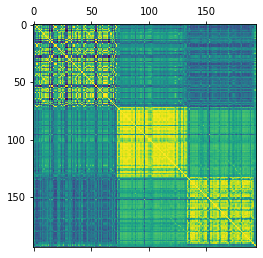

In [54]:
import matplotlib.pyplot as plt
flg = np.all(~np.isnan(whole),axis=1), np.hstack([[True, True], imputer.selection_mask[:]])
corr = np.corrcoef(whole[flg[0],:][:,flg[1]].T)
print(corr.shape)
plt.matshow(corr)

## Retrieve the categorical imputed labels

In [55]:
imputed = np.array([
    encoders[x].inverse_transform(
    y[:, c].astype(int)
 ) for c,x in enumerate(cols_to_encode)]).T

In [56]:
c40_data_imputed = c40_data.copy()

In [57]:
c40_data_imputed[cols_to_encode] = imputed

In [58]:
c40_data_imputed.head()

,city_location,c40,organisation,region,reporting_year,country,risks_to_citys_water_supply,city,account_no,access,adaptation_action,action_description,magnitude,risk_description,latitude,longitude,adaptation_action_n,action_description_n,risk_description_n
2,"(-0.2333, -78.5167)",True,Distrito Metropolitano de Quito,Latin America,2018,Ecuador,Increased water stress or scarcity,Quito,42178,public,[Conservation awareness and education],"[The Municipality of Quito, EMAAPQ ( Metropol...",Serious,[Even though water supply in Quito is not part...,-0.23330,-78.5167,1,1,1
7,"(-1.29206, 36.8219)",True,City of Nairobi,Africa,2018,Kenya,Declining water quality,Nairobi,35913,public,[Efficiency regulations or standards],[],Serious,[pollution of underground and ground water],-1.29206,36.8219,1,1,1
8,"(-1.29206, 36.8219)",True,City of Nairobi,Africa,2018,Kenya,Increased water stress or scarcity,Nairobi,35913,public,[Conservation awareness and education],[continued awareness to conserve water catchme...,Serious,[Water supply is dependent on weather],-1.29206,36.8219,1,1,1
63,"(-22.9054, -43.5614)",True,Prefeitura do Rio de Janeiro,Latin America,2018,Brazil,Inadequate or aging infrastructure,Rio de Janeiro,31176,public,[Investment in existing water supply infrastru...,[Water supply and distribution falls under Sta...,Extremely serious,[],-22.90540,-43.5614,2,2,1
64,"(-22.9054, -43.5614)",True,Prefeitura do Rio de Janeiro,Latin America,2018,Brazil,Increased water stress or scarcity,Rio de Janeiro,31176,public,[Watershed preservation],[A new law proposed by Rio City Hall was appro...,Serious,[Urban heat islands and the expected increase ...,-22.90540,-43.5614,1,2,2


## Find which labels  have been updated after imputation

In [59]:
imp_lab_freqs = c40_data_imputed[cols_to_encode].groupby(cols_to_encode,as_index=False).size()
imp_ret = pd.merge(lab_freqs, imp_lab_freqs,suffixes=('','_imp'), how='right',on=cols_to_encode)
imp_ret['increase'] = (imp_ret['size_imp'] - imp_ret['size'])/imp_ret['size']
imp_ret

,risks_to_citys_water_supply,magnitude,size,size_imp,increase
0,Declining water quality,Extremely serious,NaN,1,NaN
1,Declining water quality,Less Serious,2.0,2,0.000000
2,Declining water quality,Serious,9.0,13,0.444444
3,Energy supply issues,Extremely serious,1.0,1,0.000000
4,Energy supply issues,Serious,1.0,1,0.000000
5,Higher water prices,Extremely serious,1.0,1,0.000000
6,Higher water prices,Less Serious,1.0,1,0.000000
7,Higher water prices,Serious,1.0,4,3.000000
8,Inadequate or aging infrastructure,Extremely serious,NaN,2,NaN
9,Inadequate or aging infrastructure,Less Serious,1.0,1,0.000000


## Make sure that all risks have been encoded and are imputation outcome candidates 

In [60]:
set([x for x in cw_data['risks_to_citys_water_supply'] if x not in encoders['risks_to_citys_water_supply'].classes_])

set()

# Impute whole dataset

In [61]:
cw_data['risks_to_citys_water_supply'].value_counts()

Increased water stress or scarcity    205
Declining water quality               127
Inadequate or aging infrastructure    101
nan                                    54
Increased water demand                 49
Higher water prices                    38
Regulatory                             17
Energy supply issues                    7
Name: risks_to_citys_water_supply, dtype: int64

## Apply encoding and vectorization
**based on fitted encoders and SimilarityAnalysis objects**

In [62]:
cw_data[cols_to_encode] = cw_data[cols_to_encode].fillna('nan')
encoded = np.array([encoders[x].transform(cw_data[x]) for x in cols_to_encode]).T.astype(float)
for t in range(len(cols_to_encode)):
    encoded[encoded[:,t] == np.where(encoders[cols_to_encode[t]].classes_=='nan')[0],t] = np.nan

In [63]:
all_vectorized = np.hstack([analyses[x].transform(cw_data[x]) for x in value_columns if x in list_columns])

## Apply imputation
**using the trained imputer**

In [64]:
all_imputed_x, all_imputed_y  = imputer.transform(np.hstack([all_vectorized,cw_data[len_columns]]), encoded, ret_imputed_x=True)

[IterativeImputer] Completing matrix with shape (598, 192)
[IterativeImputer] Ending imputation round 1/5, elapsed time 0.37
[IterativeImputer] Ending imputation round 2/5, elapsed time 1.04
[IterativeImputer] Ending imputation round 3/5, elapsed time 1.68
[IterativeImputer] Ending imputation round 4/5, elapsed time 2.23
[IterativeImputer] Ending imputation round 5/5, elapsed time 2.72
[IterativeImputer] Completing matrix with shape (598, 194)
[IterativeImputer] Ending imputation round 1/2, elapsed time 0.01
[IterativeImputer] Ending imputation round 2/2, elapsed time 0.03


In [65]:
all_imputed_y_dec = np.array([
    encoders[x].inverse_transform(
    all_imputed_y[:, c].astype(int)
 ) for c,x in enumerate(cols_to_encode)]).T

In [66]:
len(cw_data[id_columns]), len(cw_data[id_columns].drop_duplicates())

(598, 598)

In [67]:
cw_data_imputed = cw_data.copy()
cw_data_imputed[cols_to_encode] = all_imputed_y_dec
cw_data_imputed.drop_duplicates(id_columns,inplace=True)

## Plot features correlation

(194, 194)


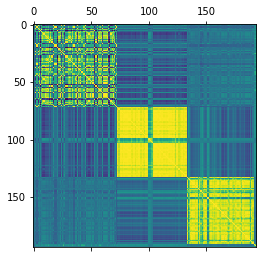

In [68]:
import matplotlib.pyplot as plt
corr = np.corrcoef(np.hstack([all_imputed_y, all_imputed_x]).T)
print(corr.shape)
plt.matshow(corr)

In [69]:
scores = cross_val_score(simple_model, all_imputed_x, all_imputed_y[:,cols_to_encode.index('magnitude')], cv=5,scoring=scoring)
np.mean(scores)

0.7307843137254901

**The score did not have significant drop, so we can assume that the imputation was cohesive across data**

## Create output dataset

In [70]:
final_labeled_data = cw_data_imputed[['city','latitude','longitude','country','c40','region','magnitude','risks_to_citys_water_supply']].copy()
final_labeled_data.rename(columns={'magnitude': 'risk','risks_to_citys_water_supply': 'description'},inplace=True)


In [71]:
final_labeled_data[['city','latitude','longitude','c40', 'region','description','risk']]

,city,latitude,longitude,c40,region,description,risk
0,Kisumu,-0.09170,34.7679,False,Africa,Declining water quality,Extremely serious
1,Kisumu,-0.09170,34.7679,False,Africa,Increased water demand,Serious
2,Quito,-0.23330,-78.5167,True,Latin America,Increased water stress or scarcity,Serious
3,Nakuru,-0.30309,36.0800,False,Africa,Declining water quality,Serious
4,Nakuru,-0.30309,36.0800,False,Africa,Inadequate or aging infrastructure,Serious
...,...,...,...,...,...,...,...
671,Aurora,88.32010,41.7606,False,North America,Increased water demand,Serious
672,Aurora,88.32010,41.7606,False,North America,Increased water stress or scarcity,Less Serious
673,Addis Ababa,9.02887,38.7544,True,Africa,Inadequate or aging infrastructure,Serious
674,Addis Ababa,9.02887,38.7544,True,Africa,Increased water demand,Serious


In [72]:
cw_data_imputed[id_columns].drop_duplicates().shape

(571, 12)

## Pivoting risks description, so that each row is unique per city

In [73]:
risks = final_labeled_data.description.unique()
risks_description = {risk: f'risk{c}' for c,risk in enumerate(risks)}
risks_df = pd.Series(risks_description).to_frame()
risks_df.reset_index(inplace=True)
risks_df.columns=['description','code']
final_labeled_data['description'] = final_labeled_data['description'].apply(lambda x: risks_description[x])
risks_df

,description,code
0,Declining water quality,risk0
1,Increased water demand,risk1
2,Increased water stress or scarcity,risk2
3,Inadequate or aging infrastructure,risk3
4,Higher water prices,risk4
5,Energy supply issues,risk5
6,Regulatory,risk6


In [74]:
final_labeled_data = final_labeled_data.pivot(index=['city','latitude','longitude','c40', 'country'], columns='description', values='risk').reset_index()

In [75]:
final_labeled_data.to_csv(os.path.join(LABELED_DIR, "labeled_cities.csv"),index=False)
risks_df.to_csv(os.path.join(LABELED_DIR, "risks_mapping.csv"),index=False)

In [76]:
final_labeled_data.head()

description,city,latitude,longitude,c40,country,risk0,risk1,risk2,risk3,risk4,risk5,risk6
0,Abasan Al-Kabira,31.32310,34.34400,False,State of Palestine,Serious,NaN,Serious,Serious,NaN,NaN,NaN
1,Abington,40.12410,-75.11950,False,United States of America,Serious,NaN,Less Serious,Less Serious,NaN,NaN,NaN
2,Abuja,9.07647,7.39857,False,Nigeria,NaN,NaN,Serious,Serious,Serious,NaN,NaN
3,Addis Ababa,9.02887,38.75440,True,Ethiopia,NaN,Serious,Serious,Serious,NaN,NaN,NaN
4,Adelaide,-34.92850,138.60100,False,Australia,NaN,NaN,Serious,Serious,Serious,NaN,Serious


## See a report of the filled labels

In [77]:
cw_lab_freqs = cw_data[cols_to_encode].groupby(cols_to_encode,as_index=False).size()
imp_cw_lab_freqs = cw_data_imputed[cols_to_encode].groupby(cols_to_encode,as_index=False).size()
imp_cw_ret = pd.merge(cw_lab_freqs, imp_cw_lab_freqs,suffixes=('','_imp'), how='right',on=cols_to_encode)
imp_cw_ret['increase'] = (imp_cw_ret['size_imp'] - imp_cw_ret['size'])/imp_cw_ret['size']
imp_cw_ret

,risks_to_citys_water_supply,magnitude,size,size_imp,increase
0,Declining water quality,Extremely serious,23,25,0.086957
1,Declining water quality,Less Serious,18,18,0.000000
2,Declining water quality,Serious,57,89,0.561404
3,Energy supply issues,Extremely serious,1,1,0.000000
4,Energy supply issues,Less Serious,1,1,0.000000
5,Energy supply issues,Serious,5,5,0.000000
6,Higher water prices,Extremely serious,2,2,0.000000
7,Higher water prices,Less Serious,10,10,0.000000
8,Higher water prices,Serious,14,26,0.857143
9,Inadequate or aging infrastructure,Extremely serious,3,6,1.000000


In [78]:
imp_report = pd.merge(imp_cw_ret, imp_ret, suffixes=('','_c40'), on=('magnitude','risks_to_citys_water_supply'))
imp_report.to_csv(os.path.join(LABELED_DIR, 'labeled_cities_imputation_report.csv'),index=False)
imp_report

,risks_to_citys_water_supply,magnitude,size,size_imp,increase,size_c40,size_imp_c40,increase_c40
0,Declining water quality,Extremely serious,23,25,0.086957,NaN,1,NaN
1,Declining water quality,Less Serious,18,18,0.000000,2.0,2,0.000000
2,Declining water quality,Serious,57,89,0.561404,9.0,13,0.444444
3,Energy supply issues,Extremely serious,1,1,0.000000,1.0,1,0.000000
4,Energy supply issues,Serious,5,5,0.000000,1.0,1,0.000000
5,Higher water prices,Extremely serious,2,2,0.000000,1.0,1,0.000000
6,Higher water prices,Less Serious,10,10,0.000000,1.0,1,0.000000
7,Higher water prices,Serious,14,26,0.857143,1.0,4,3.000000
8,Inadequate or aging infrastructure,Extremely serious,3,6,1.000000,NaN,2,NaN
9,Inadequate or aging infrastructure,Less Serious,8,8,0.000000,1.0,1,0.000000
